In [ ]:
!wget --no-check-certificate "https://ivg.au.tsinghua.edu.cn/dataset/samples_THUPALMLAB/THUPALMLAB.rar" -O THUPALMLAB.rar

--2025-03-18 15:49:34--  https://ivg.au.tsinghua.edu.cn/dataset/samples_THUPALMLAB/THUPALMLAB.rar
Resolving ivg.au.tsinghua.edu.cn (ivg.au.tsinghua.edu.cn)... 101.6.15.70, 2402:f000:1:402:101:6:15:70
Connecting to ivg.au.tsinghua.edu.cn (ivg.au.tsinghua.edu.cn)|101.6.15.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3535915674 (3.3G) [application/x-rar-compressed]
Saving to: ‘THUPALMLAB.rar’

THUPALMLAB.rar      100%[===================>]   3.29G  12.3MB/s    in 4m 32s  

2025-03-18 15:54:07 (12.4 MB/s) - ‘THUPALMLAB.rar’ saved [3535915674/3535915674]



In [ ]:
!unrar x THUPALMLAB.rar


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from THUPALMLAB.rar

Creating    image                                                     OK
Extracting  image/10_l_1.bmp                                               0%  OK 
Extracting  image/10_l_2.bmp                                               0%  OK 
Extracting  image/10_l_3.bmp                                               0%  OK 
Extracting  image/10_l_4.bmp                                               0%  OK 
Extracting  image/10_l_5.bmp                                               0%  OK 
Extracting  image/10_l_6.bmp                                               0%  OK 
Extracting  image/10_l_7.bmp                                               0%  OK 
Extracting  image/10_l_8.bmp                                               0%  OK 
Extracting  image/10_r_1.bmp                                               0%

In [ ]:
import os
import random
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm

In [ ]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
def load_and_preprocess_images(directory, target_size=(128, 128)):
    data = {}
    for filename in tqdm(os.listdir(directory)):
        if filename.endswith(".bmp"):
            path = os.path.join(directory, filename)
            image = load_img(path, target_size=target_size, color_mode='grayscale')
            image = img_to_array(image) / 255.0
            parts = filename.split('_')
            subject_id, hand, number = parts[0], parts[1], parts[2].split('.')[0]
            if subject_id not in data:
                data[subject_id] = {"l": [], "r": []}
            data[subject_id][hand].append((image, number))
    return data

In [ ]:
def create_pairs(data):
    pairs = []
    labels = []
    classes = []
    subjects = list(data.keys())
    similar_pairs = []
    dissimilar_pairs = []

    for subject in subjects:
        for hand in ['l', 'r']:
            images = data[subject][hand]
            for i in range(len(images)):
                for j in range(i + 1, len(images)):
                    similar_pairs.append(((images[i][0], images[j][0]), 1, ((subject, hand, images[i][1]), (subject, hand, images[j][1]))))
    num_similar = len(similar_pairs)
    subject_pairs = list(set([(s1, s2) for s1 in subjects for s2 in subjects if s1 != s2]))
    random.shuffle(subject_pairs)

    while len(dissimilar_pairs) < num_similar:
        for subject1, subject2 in subject_pairs:
            if len(dissimilar_pairs) >= num_similar:
                break
            for hand in ['l', 'r']:
                if data[subject1][hand] and data[subject2][hand]:
                    img1, num1 = random.choice(data[subject1][hand])
                    img2, num2 = random.choice(data[subject2][hand])
                    dissimilar_pairs.append(((img1, img2), 0, ((subject1, hand, num1), (subject2, hand, num2))))

    combined = similar_pairs + dissimilar_pairs
    random.shuffle(combined)
    pairs, labels, classes = zip(*combined)

    return np.array(pairs), np.array(labels), classes

In [ ]:
def visualize_images(data, num_samples=5):
    plt.figure(figsize=(10, 5))
    subjects = random.sample(list(data.keys()), num_samples)

    for i, subject in enumerate(subjects):
        hand = random.choice(['l', 'r'])
        if data[subject][hand]:
            img, num = random.choice(data[subject][hand])
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(img.squeeze(), cmap='gray')
            plt.title(f"Subject {subject}\n({'Left' if hand == 'l' else 'Right'}) {hand.upper()}{num}", pad=10)
            plt.axis('off')

    plt.show()

In [ ]:
def visualize_test_data(pairs, labels, classes, num_samples=5):
    plt.figure(figsize=(10, 5))
    indices = np.random.choice(len(pairs), num_samples, replace=False)
    for i, idx in enumerate(indices):
        img1, img2 = pairs[idx]
        label = labels[idx]
        class1, hand1, num1 = classes[idx][0]
        class2, hand2, num2 = classes[idx][1]
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(img1.squeeze(), cmap='gray')
        plt.title(f"Class: {class1} {hand1.upper()}{num1}")
        plt.axis('off')
        plt.subplot(2, num_samples, i + 1 + num_samples)
        plt.imshow(img2.squeeze(), cmap='gray')
        plt.title(f"Class: {class2} {hand2.upper()}{num2}\nLabel: {label}")
        plt.axis('off')
    plt.show()

In [ ]:
def split_dataset(pairs, labels, test_size=0.2, dev_size=0.1):
    train_pairs, test_pairs, train_labels, test_labels = train_test_split(
        pairs, labels, test_size=test_size, random_state=SEED)
    train_pairs, dev_pairs, train_labels, dev_labels = train_test_split(
        train_pairs, train_labels, test_size=dev_size, random_state=SEED)
    return train_pairs, train_labels, dev_pairs, dev_labels, test_pairs, test_labels

In [ ]:
def build_siamese_model(input_shape=(128, 128, 1)):
    input_img = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)

    return Model(input_img, x)

def build_model():
    base_network = build_siamese_model()
    input_a = Input(shape=(128, 128, 1))
    input_b = Input(shape=(128, 128, 1))

    processed_a = base_network(input_a)
    processed_b = base_network(input_b)

    merged = Concatenate()([processed_a, processed_b])
    merged = Dense(128, activation='relu')(merged)
    merged = Dropout(0.5)(merged)
    merged = Dense(1, activation='sigmoid')(merged)

    model = Model(inputs=[input_a, input_b], outputs=merged)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def evaluate_model(model, test_pairs, test_labels):
    predictions = model.predict([test_pairs[:, 0], test_pairs[:, 1]])
    pred_labels = (predictions > 0.5).astype(int)
    cm = confusion_matrix(test_labels, pred_labels)
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", classification_report(test_labels, pred_labels))

    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [ ]:
dataset_path = "./image"
image_data = load_and_preprocess_images(dataset_path)

100%|██████████| 1280/1280 [00:29<00:00, 43.12it/s]


In [ ]:
image_data.keys()

dict_keys(['45', '141', '65', '16', '159', '21', '26', '31', '24', '150', '33', '4', '40', '66', '36', '70', '38', '154', '160', '34', '60', '50', '56', '44', '57', '155', '39', '30', '2', '22', '58', '10', '51', '18', '23', '17', '29', '20', '62', '64', '54', '9', '5', '63', '7', '68', '52', '25', '35', '37', '19', '158', '151', '3', '69', '53', '14', '11', '1', '27', '41', '156', '61', '67', '152', '47', '59', '15', '49', '157', '153', '28', '43', '42', '46', '48', '6', '12', '13', '8'])

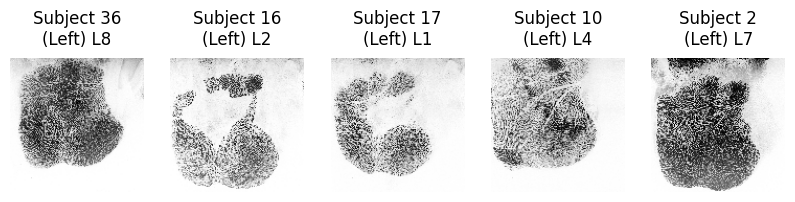

In [ ]:
visualize_images(image_data, num_samples=5)

In [ ]:
pairs, labels, classes = create_pairs(image_data)
print("Dataset created with", len(pairs), "pairs")

Dataset created with 8960 pairs


In [ ]:
pairs.shape, labels.shape

((8960, 2, 128, 128, 1), (8960,))

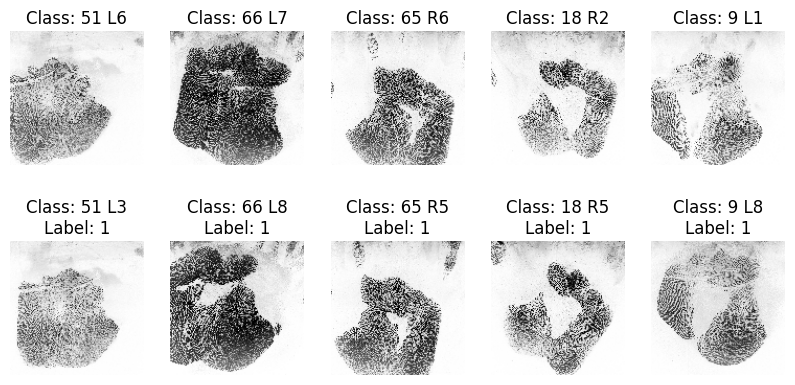

In [ ]:
visualize_test_data(pairs, labels, classes, num_samples=5)

In [ ]:
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))

{0: 4480, 1: 4480}


In [ ]:
train_pairs, train_labels, dev_pairs, dev_labels, test_pairs, test_labels = split_dataset(pairs, labels,test_size=0.2, dev_size=0.1)

In [ ]:
train_pairs.shape, train_labels.shape, dev_pairs.shape, dev_labels.shape, test_pairs.shape, test_labels.shape

((6451, 2, 128, 128, 1),
 (6451,),
 (717, 2, 128, 128, 1),
 (717,),
 (1792, 2, 128, 128, 1),
 (1792,))

In [ ]:
def plot_training_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    ax[0].plot(history.history['loss'], label='Train Loss')
    ax[0].plot(history.history['val_loss'], label='Validation Loss')
    ax[0].set_title('Loss over Epochs')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(history.history['accuracy'], label='Train Accuracy')
    ax[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[1].set_title('Accuracy over Epochs')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    plt.show()

In [ ]:
model = build_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 128, 128, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional (Functional)   │ (None, 128)            │      8,407,552 │ input_layer_1[0][0],   │
│                           │                        │                │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 256)            │              0 │ functional[0][0],      │
│                           │                        │                │ functional[1][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128)            │         32,896 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │            129 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 8,440,577 (32.20 MB)

 Trainable params: 8,440,577 (32.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.5082 - loss: 0.7536 - val_accuracy: 0.4854 - val_loss: 0.6934
Epoch 2/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5110 - loss: 0.6931 - val_accuracy: 0.4854 - val_loss: 0.6934
Epoch 3/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.5102 - loss: 0.6931 - val_accuracy: 0.4854 - val_loss: 0.6934
Epoch 4/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5113 - loss: 0.6931 - val_accuracy: 0.4854 - val_loss: 0.6935
Epoch 5/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5101 - loss: 0.6930 - val_accuracy: 0.4854 - val_loss: 0.6934
Epoch 6/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5071 - loss: 0.6885 - val_accuracy: 0.7238 - val_loss: 0.6260
Epoch 7/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.7471 - loss: 0.5364 - val_accuracy: 0.7615 - val_loss: 0.5318
Epoch 8/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.8023 - loss: 0.4487 - val_

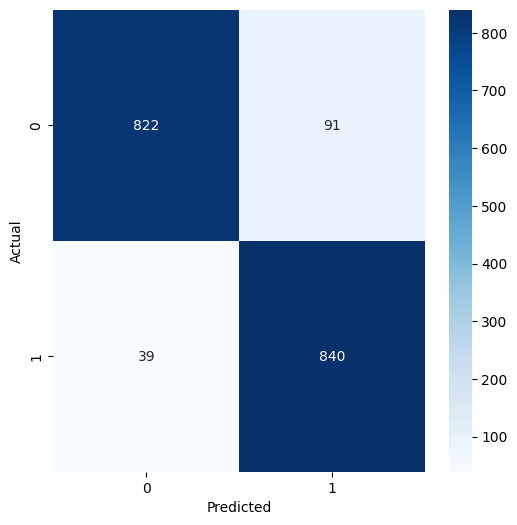

In [ ]:
model = build_model()
history = model.fit([train_pairs[:, 0], train_pairs[:, 1]], train_labels,
                    validation_data=([dev_pairs[:, 0], dev_pairs[:, 1]], dev_labels),
                    epochs=50, batch_size=32, callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])
evaluate_model(model, test_pairs, test_labels)

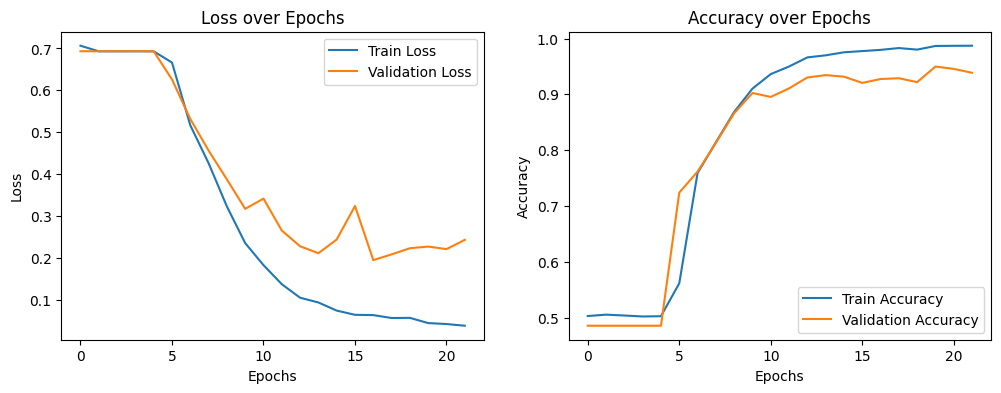

In [ ]:
plot_training_history(history)

In [ ]:
best_epoch = history.history['val_loss'].index(min(history.history['val_loss']))
best_val_acc = history.history['val_accuracy'][best_epoch]
best_val_loss = history.history['val_loss'][best_epoch]
y_pred = model.predict([test_pairs[:, 0], test_pairs[:, 1]])
y_pred_classes = (y_pred > 0.5).astype(int)
precision = precision_score(test_labels, y_pred_classes)
recall = recall_score(test_labels, y_pred_classes)
f1 = f1_score(test_labels, y_pred_classes)

print(f"Validation Accuracy: {best_val_acc:.4f}")
print(f"Lower Validation Loss: {best_val_loss:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Validation Accuracy: 0.9275
Lower Validation Loss: 0.1948
Precision: 0.9023
Recall: 0.9556
F1 Score: 0.9282


In [ ]:
model.save_weights("model.weights.h5")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Confusion Matrix:
 [[822  91]
 [ 39 840]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.90      0.93       913
           1       0.90      0.96      0.93       879

    accuracy                           0.93      1792
   macro avg       0.93      0.93      0.93      1792
weighted avg       0.93      0.93      0.93      1792



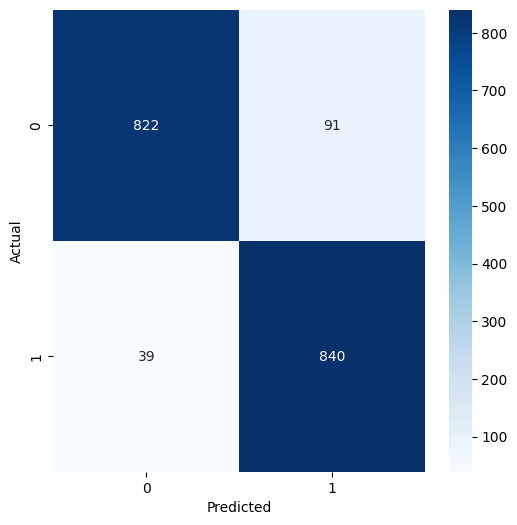

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [ ]:
model = build_model()

model.load_weights("/content/model.weights.h5")

evaluate_model(model, test_pairs, test_labels)

y_pred = model.predict([test_pairs[:, 0], test_pairs[:, 1]])
y_pred_classes = (y_pred > 0.5).astype(int)

conf_matrix = confusion_matrix(test_labels, y_pred_classes)

In [ ]:
def biometric_authenticate(model, user_id, input_image, dataset):
    user_images = dataset.get(user_id, None)
    if user_images is None:
        print("User ID not found!")
        return

    stored_image, _ = random.choice(user_images['l'] + user_images['r'])

    prediction = model.predict([np.expand_dims(stored_image, axis=0), np.expand_dims(input_image, axis=0)])[0][0]

    print(f"Similarity Score: {prediction:.4f}")
    if prediction > 0.5:
        print("Authentication Successful: User Verified!")
    else:
        print("Authentication Failed: User Mismatch!")

    fig, ax = plt.subplots(1, 2, figsize=(6, 3))
    ax[0].imshow(stored_image.squeeze(), cmap='gray')
    ax[0].set_title("Stored Image")
    ax[0].axis('off')
    ax[1].imshow(input_image.squeeze(), cmap='gray')
    ax[1].set_title("Input Image")
    ax[1].axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Similarity Score: 0.9229
Authentication Successful: User Verified!


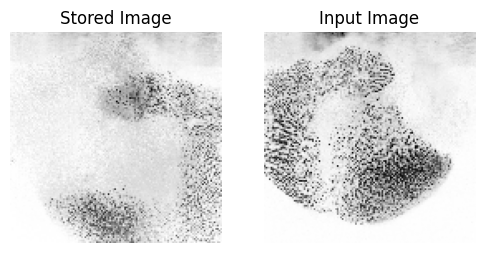

In [ ]:
random_user = random.choice(list(image_data.keys()))
random_hand = random.choice(['l', 'r'])
random_input_image, _ = random.choice(image_data[random_user][random_hand])

biometric_authenticate(model, random_user, random_input_image, image_data)